In [18]:
import os, sys
pgm_path = 'PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')

import rbm, RBM_utils
import utilities, Proteins_utils, sequence_logo, plots_utils 

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

from global_variables import *
%matplotlib inline

In [3]:
path = 'seq_data/'
filename = 'rbd_aligned_sequences.fasta'

In [4]:
sequences = Proteins_utils.load_FASTA(path + filename) # Load protein sequences.
#shape
print('shape of sequences:', np.shape(sequences))
print('sequences:', sequences)


sequences=np.array(sequences)

shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]


In [5]:
WT_SEQ.shape

(178,)

Max distance: 166


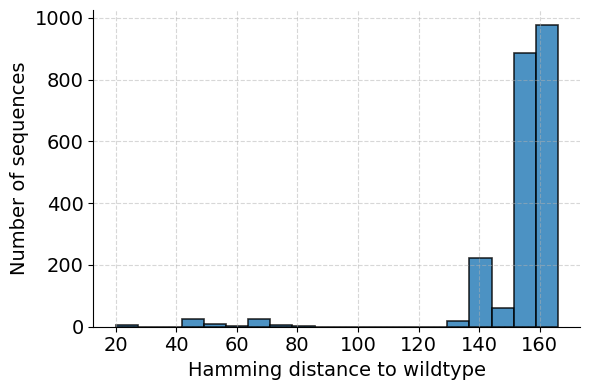

In [6]:

def hamming_distance(s1, s2):
    #check same length
    assert len(s1) == len(s2)
    
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

distances = np.array([hamming_distance(WT_SEQ, seq) for seq in sequences])
print('Max distance:', np.max(distances))

# Create the figure
plt.figure(figsize=(6, 4))  # Slightly larger figure for clarity

# Plotting histogram with enhanced visualization
plt.hist(distances, bins=20, color='#1f77b4', edgecolor='black', linewidth=1.2, alpha=0.8)

# Enhancing the plot for publication
plt.xlabel('Hamming distance to wildtype', fontsize=14)
plt.ylabel('Number of sequences', fontsize=14)

# Adding subtle grid with better style
plt.grid(True, which='both', linestyle='--', linewidth=0.8, alpha=0.5)

# Customizing ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Removing top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [7]:
perm = np.arange(sequences.shape[0])
#fix seed
np.random.seed(2)
np.random.shuffle(perm)

len_validation = sequences.shape[0] // 10
train_sequences=sequences[perm[:-len_validation]]
validation_sequences=sequences[perm[-len_validation:]]
rand_data = np.random.randint(low=0, high=20, size=train_sequences.shape, dtype=np.int16)

print('Train sequences shape:', train_sequences.shape)
print('Validation sequences shape:', validation_sequences.shape)
print('Random data shape:', rand_data.shape)

#unfix seed
np.random.seed(None)


Train sequences shape: (2016, 178)
Validation sequences shape: (224, 178)
Random data shape: (2016, 178)


In [8]:

train_sequences=np.vstack([WT_SEQ, train_sequences])
print('Train sequences shape:', train_sequences.shape)


Train sequences shape: (2017, 178)


## Train RBM on prepandemic sequences

In [9]:

#TODO : uncomment to train RBM again
# sequence_weights = 1.0/Proteins_utils.count_neighbours(train_sequences) # Compute sequence weights.
#uniform weights
sequence_weights = np.ones(train_sequences.shape[0])
#first seq should have higher weight

# RBM = rbm.RBM(
#               visible = 'Potts', # Categorical visible data.
#               hidden = 'dReLU', # double ReLU hidden units.
#               n_v = sequences.shape[-1], # Data dimension (here, number of columns in MSA)
#               n_cv = 21, # Number of categories (here, 20 amino acids + 1 gap)
#               n_h = 100 # Number of hidden units: 100
#               ) # RBM object initialization.

# RBM.fit(train_sequences, weights = sequence_weights, n_iter=50, N_MC=10,verbose=1, vverbose=1, l1b=0.12) # Fit by Persistent Contrastive Divergence for 500 epochs, 10 Monte Carlo steps; L_1^2 sparse regularization penalty = 0.1.
# RBM_utils.saveRBM('test_wt_RBM_Covid.data',RBM)
# print( RBM.likelihood(train_sequences).mean() ) # Evaluate partition function Z by Annealed Importance Sampling, then evaluate  sequences likelihood.

# plots_utils.make_all_weights(RBM,sequences,name = 'all_weights_WW.pdf',pdb_file='2n1o') # For each hidden unit of the trained RBM model, show weight logo, input distribution and  attached for all hidden units and map them onto a PDB structure.


In [10]:
RBM=RBM_utils.loadRBM('test_wt_RBM_Covid.data')


Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


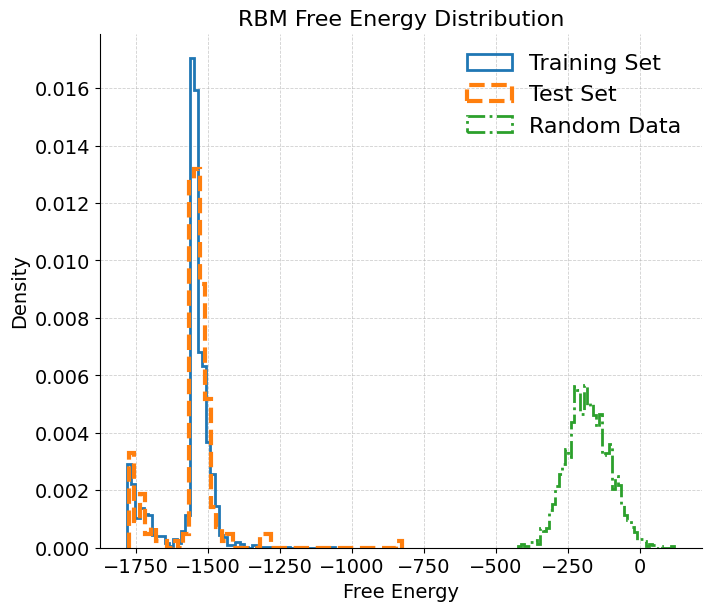

In [11]:
# Create the figure
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

# Plot histogram with enhanced visibility
ax.hist(RBM.free_energy(train_sequences), bins=50, density=True, histtype='step', 
        lw=2, linestyle='-', color='#1f77b4', label="Training Set")

ax.hist(RBM.free_energy(validation_sequences), bins=50, density=True, histtype='step', 
        lw=3, linestyle='--', color='#ff7f0e', label="Test Set")

ax.hist(RBM.free_energy(rand_data), bins=50, density=True, histtype='step', 
        lw=2, linestyle='-.', color='#2ca02c', label="Random Data")

# Enhancing aesthetics
ax.set_xlabel("Free Energy", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("RBM Free Energy Distribution", fontsize=16)

# Adding likelihood annotation inside the plot
mean_likelihood = RBM.likelihood(validation_sequences).mean()

# Customizing legend
ax.legend(fontsize=16, loc='upper right', frameon=False)

# Customizing ticks and grid
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Removing top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()

# Application to df bloom

# protein Expression

In [12]:
df_bloom=pd.read_csv('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
#reset index
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')


In [13]:
df_bloom.shape

(3327, 13)

In [14]:
bloom_sequences=Proteins_utils.load_FASTA('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)
bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

In [16]:
df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [17]:

sequences_likelihood = RBM.likelihood(bloom_sequences)
df_bloom['likelihood'] = sequences_likelihood
#replace nan by -300
sequences_likelihood

array([35.73755 , 26.215088, 35.795166, ..., 33.947998, 33.641113,
       22.592651], dtype=float32)

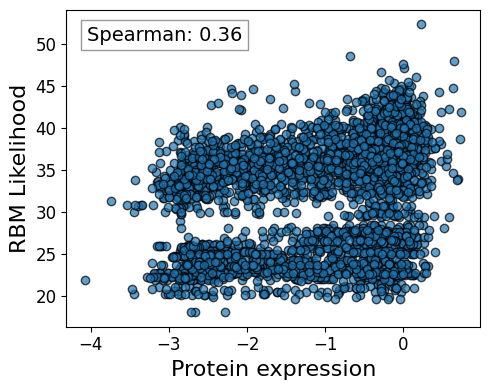

(0.35795432273925204, 3.856864712722513e-101, -1078.5872141865789)

In [19]:
x = df_bloom['expr_avg']
y = df_bloom['likelihood']

# Metrics
spearman_corr, spearman_pval = stats.spearmanr(x, y)
r2 = r2_score(x, y)

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='#1f77b4', alpha=0.7, edgecolor='black')

plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Likelihood', fontsize=16)

# Stats box
plt.text(
    0.05, 0.95, f"Spearman: {spearman_corr:.2f}",
    transform=plt.gca().transAxes, fontsize=14, va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey')
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

spearman_corr, spearman_pval, r2


# Grouping by site

In [20]:
WT_embe=Proteins_utils.load_FASTA('seq_data/rbd_wt.fasta')
WT_embe = [seq[BEGIN:-END] for seq in WT_embe]
WT_embe=np.array(WT_embe)
likelihood_WT = RBM.likelihood(WT_embe)
print('likelihood_WT:', likelihood_WT)

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I
likelihood_WT: [42.69641]


In [21]:
df_bloom['deltaE'] = -likelihood_WT+df_bloom['likelihood']
df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,likelihood,deltaE
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,35.737549,-6.958862
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...,26.215088,-16.481323
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...,35.795166,-6.901245
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...,38.091187,-4.605225
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...,26.214844,-16.481567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,32.609619,-10.086792
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,35.276367,-7.420044
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,33.947998,-8.748413
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,33.641113,-9.055298


In [22]:
df_bloom_avg = df_bloom.groupby('site_SARS2').agg(lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.iloc[0]).reset_index()



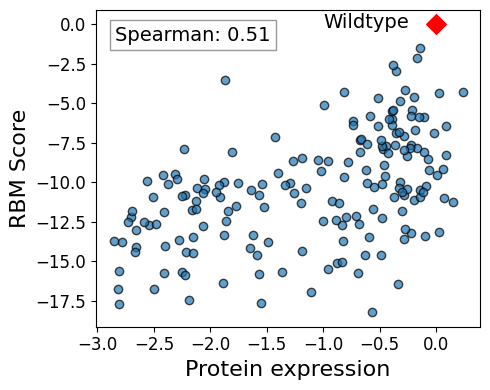

(0.5053839172958808, 6.261294035859421e-13, -121.48752639683865)

In [23]:
# Calculate Spearman correlation
spearman_corr, spearman_pval = stats.spearmanr(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Calculate R² score
r2 = r2_score(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Create figure
plt.figure(figsize=(5, 4))  # Slightly larger for readability

# Scatter plot with enhanced visualization
plt.scatter(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'], color='#1f77b4', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Score', fontsize=16)
# plt.title(r'$\Delta E_{RBM}$ vs Expression Average', fontsize=16)

# Adding Spearman correlation in a small box inside the plot
textstr = f"Spearman: {spearman_corr:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))

# Grid and ticks
# plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Removing top and right spines for a cleaner look
ax = plt.gca()

plt.scatter(0, 0, color='red', marker='D', s=100, label='Wildtype')
#annotate
plt.annotate('Wildtype', xy=(0, 0), xytext=(-1,- 0.2),
             fontsize=14)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Print correlation and R² score
spearman_corr, spearman_pval, r2


# RBM epistasis

In [24]:
artificial_seq,artificial_sequences_representation = RBM.gen_data(Nthermalize=1000,Nchains=100,Lchains=100,Nstep=50) # Generate artificial samples by Markov Chain Monte Carlo.
msa_seq=Proteins_utils.load_FASTA('seq_data/rbd_aligned_sequences.fasta')


Mismatch dimensions (10, 100), [100, 100], reinitializating I
Mismatch dimensions (10, 178, 21), [100, 178, 21], reinitializating I


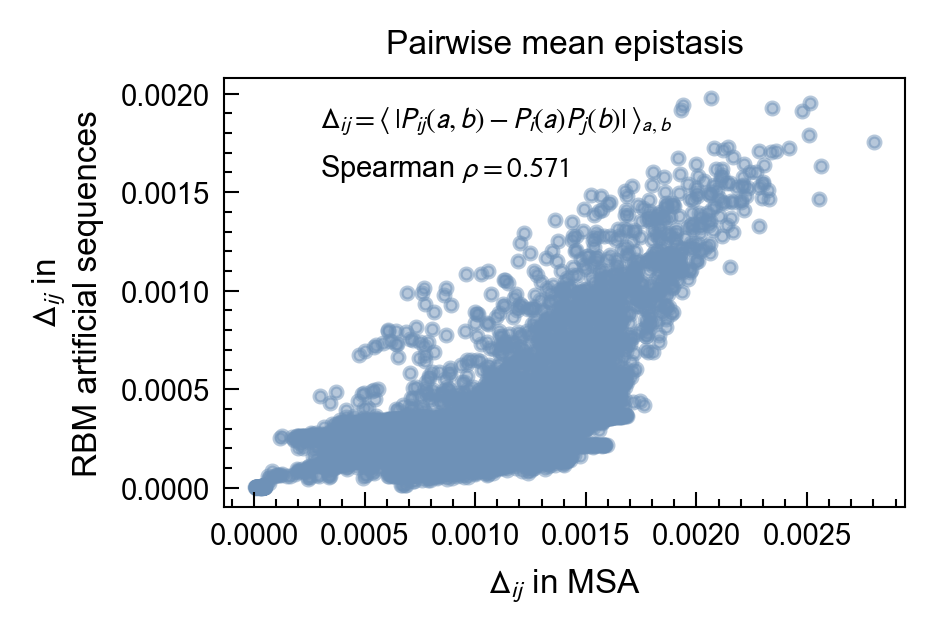

In [ ]:

from plot_utils import nature_rc, nature_figsize, finalize_axes
nature_rc()


# ===================== helpers =====================

def _single_marginals(seqs, q, weights=None, ignore_index=None, pseudocount=1e-6):
    """
    seqs: (N, L) int in [0, q-1]
    Returns Pi: (L, q) with symmetric pseudocount smoothing.
    """
    N, L = seqs.shape
    if weights is None:
        weights = np.ones(N, dtype=float)

    Pi = np.zeros((L, q), dtype=float)
    for i in range(L):
        vi = seqs[:, i]
        if ignore_index is None:
            keep = np.ones(N, dtype=bool)
        else:
            keep = (vi != ignore_index)

        if not np.any(keep):
            Pi[i] = 1.0 / q
            continue

        w = weights[keep]
        vi = vi[keep]
        cnt = np.bincount(vi, weights=w, minlength=q).astype(float)

        cnt += pseudocount
        denom = w.sum() + q * pseudocount
        Pi[i] = cnt / denom
    return Pi


def _pair_counts(vi, vj, weights, q, ignore_index=None):
    """
    Weighted contingency table for a pair of columns.
    Returns M (q x q) and effective sample size n.
    """
    if ignore_index is None:
        keep = np.ones_like(vi, dtype=bool)
    else:
        keep = (vi != ignore_index) & (vj != ignore_index)

    vi = vi[keep]
    vj = vj[keep]
    if weights is None:
        w = np.ones_like(vi, dtype=float)
    else:
        w = weights[keep]

    M = np.zeros((q, q), dtype=float)
    if vi.size:
        np.add.at(M, (vi, vj), w)
    return M, float(w.sum())


def mean_abs_delta_matrix(seqs, q=None, weights=None, ignore_index=None, pseudocount=1e-6):
    """
    Compute matrix D where D[i,j] = mean_{a,b} |P_ij(a,b) - P_i(a)P_j(b)|.
    """
    N, L = seqs.shape
    if q is None:
        q = int(seqs.max()) + 1

    Pi = _single_marginals(seqs, q, weights=weights, ignore_index=ignore_index, pseudocount=pseudocount)
    D = np.zeros((L, L), dtype=float)

    for i in range(L):
        vi = seqs[:, i]
        Pi_i = Pi[i]
        for j in range(i + 1, L):
            vj = seqs[:, j]
            C, n = _pair_counts(vi, vj, weights, q, ignore_index=ignore_index)

            # symmetric pseudocount on pairs
            C += pseudocount
            denom = n + (q * q) * pseudocount
            Pij = C / denom

            Delta = Pij - np.outer(Pi_i, Pi[j])
            D_ij = np.abs(Delta).mean()  # average over (a,b)
            D[i, j] = D[j, i] = D_ij
    return D


def upper_tri_flat(M):
    iu = np.triu_indices(M.shape[0], k=1)
    return M[iu]


def safe_corr(a, b):
    """Pearson correlation with small-sample safety."""
    a = np.asarray(a)
    b = np.asarray(b)
    if a.size < 2 or b.size < 2:
        return np.nan
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a*a).sum() * (b*b).sum())
    return float((a*b).sum() / denom) if denom > 0 else np.nan


def _rankdata_avg(a):
    """
    Average-rank tie handling (1-based ranks), NumPy-only.
    """
    a = np.asarray(a)
    order = np.argsort(a, kind="mergesort")
    ranks = np.empty_like(order, dtype=float)
    sorted_a = a[order]
    n = a.size
    i = 0
    while i < n:
        j = i
        # group ties
        while j + 1 < n and sorted_a[j + 1] == sorted_a[i]:
            j += 1
        # average rank for the tie group
        rank = 0.5 * (i + j) + 1.0
        ranks[order[i:j + 1]] = rank
        i = j + 1
    return ranks


def safe_spearman(a, b):
    """
    Spearman rho via Pearson on average ranks. Returns NaN if degenerate.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    if a.size < 2 or b.size < 2:
        return np.nan
    ra = _rankdata_avg(a)
    rb = _rankdata_avg(b)
    return safe_corr(ra, rb)



ignore_index = None 
weights_msa = None
weights_rbm = None

q = int(max(msa_seq.max(), artificial_seq.max())) + 1

# ===================== compute =====================
D_msa = mean_abs_delta_matrix(msa_seq, q=q, weights=weights_msa, ignore_index=ignore_index)
D_rbm = mean_abs_delta_matrix(artificial_seq, q=q, weights=weights_rbm, ignore_index=ignore_index)

# ---------- Pairwise scatter: RBM vs MSA ----------
x_pairs = upper_tri_flat(D_msa)
y_pairs = upper_tri_flat(D_rbm)

# Spearman correlation
rho_s = safe_spearman(x_pairs, y_pairs)

fig, ax = plt.subplots(figsize=(3, 2), constrained_layout=True)
sc = ax.scatter(x_pairs, y_pairs, s=8, alpha=0.5)
m = float(max(x_pairs.max(initial=0.0), y_pairs.max(initial=0.0), 1e-6))

ax.set_xlabel(r"$\Delta_{ij}$ in MSA")
ax.set_ylabel("$\\Delta_{ij}$ in\nRBM artificial sequences")
ax.set_title("Pairwise mean epistasis")

# Legend: Δ_ij definition + Spearman rho
ax.plot([], [], ' ', label=r"$\Delta_{ij}=\left\langle\,|P_{ij}(a,b)-P_i(a)P_j(b)|\,\right\rangle_{a,b}$")
ax.plot([], [], ' ', label=rf"Spearman $\rho={rho_s:.3f}$")

ax.legend(loc="best")
finalize_axes(ax, minor=True, trim_spines=False)

plt.show()
